In [2]:
import csv
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

TypeError: Descriptors cannot not be created directly.
If this call came from a _pb2.py file, your generated code is out of date and must be regenerated with protoc >= 3.19.0.
If you cannot immediately regenerate your protos, some other possible workarounds are:
 1. Downgrade the protobuf package to 3.20.x or lower.
 2. Set PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python (but this will use pure-Python parsing and will be much slower).

More information: https://developers.google.com/protocol-buffers/docs/news/2022-05-06#python-updates

# Specify each path

In [2]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [3]:
NUM_CLASSES = 26

# Dataset reading

In [6]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [7]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [8]:
unique, counts = np.unique(y_dataset, return_counts=True)
dict(zip(unique, counts))

{0: 296,
 1: 349,
 2: 307,
 3: 328,
 4: 305,
 5: 503,
 6: 268,
 7: 299,
 8: 404,
 9: 247,
 10: 393,
 11: 417,
 12: 307,
 13: 278,
 14: 247,
 15: 258,
 16: 289,
 17: 300,
 18: 409,
 19: 337,
 20: 323,
 21: 311,
 22: 357,
 23: 221,
 24: 404,
 25: 282}

# Balancing

In [9]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_dataset, y_dataset)

In [10]:
X_res.shape

(13078, 42)

In [11]:
unique, counts = np.unique(y_res, return_counts=True)
dict(zip(unique, counts))

{0: 503,
 1: 503,
 2: 503,
 3: 503,
 4: 503,
 5: 503,
 6: 503,
 7: 503,
 8: 503,
 9: 503,
 10: 503,
 11: 503,
 12: 503,
 13: 503,
 14: 503,
 15: 503,
 16: 503,
 17: 503,
 18: 503,
 19: 503,
 20: 503,
 21: 503,
 22: 503,
 23: 503,
 24: 503,
 25: 503}

# Split Data

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, train_size=0.75, random_state=RANDOM_SEED, stratify=y_res)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.75, random_state=RANDOM_SEED, stratify=y_train)

In [13]:
X_train.shape

(7356, 42)

# Model building

In [28]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [29]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_4 (Dropout)         (None, 42)                0         
                                                                 
 dense_6 (Dense)             (None, 512)               22016     
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 256)               131328    
                                                                 
 dense_8 (Dense)             (None, 26)                6682      
                                                                 
Total params: 160,026
Trainable params: 160,026
Non-trainable params: 0
_________________________________________________________________


In [30]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)

In [31]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [32]:
history = model.fit(
    X_train,
    y_train,
    epochs=150,
    batch_size=128,
    validation_data=(X_val, y_val),
    callbacks=[cp_callback]
)

Epoch 1/150
49/58 [========================>.....] - ETA: 0s - loss: 2.8318 - accuracy: 0.1709
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
58/58 [==============================] - 1s 11ms/step - loss: 2.7581 - accuracy: 0.1890 - val_loss: 1.9768 - val_accuracy: 0.4702
Epoch 2/150
57/58 [============================>.] - ETA: 0s - loss: 1.9565 - accuracy: 0.3820
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
58/58 [==============================] - 0s 7ms/step - loss: 1.9538 - accuracy: 0.3827 - val_loss: 1.2822 - val_accuracy: 0.6860
Epoch 3/150
52/58 [=========================>....] - ETA: 0s - loss: 1.6926 - accuracy: 0.4510
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
58/58 [==============================] - 0s 7ms/step - loss: 1.6861 - accuracy: 0.4520 - val_loss: 1.0193 - val_accuracy: 0.7529
Epoch 4/150
52/58 [=========================>....] - ETA: 0s - loss: 1.4857 - accuracy: 0.5159
Epoc

In [33]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

26/26 [==============================] - 0s 2ms/step - loss: 0.1806 - accuracy: 0.9394


In [34]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [35]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 138ms/step
[4.6630620e-07 2.6819175e-10 1.6843983e-09 1.1387814e-03 2.0282873e-09
 1.4636337e-10 1.1791508e-03 1.7244048e-02 4.0835555e-08 1.1094546e-04
 1.2290689e-06 2.8721445e-07 1.0385466e-05 8.6543487e-06 5.6600419e-07
 1.8677962e-05 2.1398475e-06 6.7678452e-06 3.1850570e-06 9.8009461e-01
 3.5270126e-08 3.7083225e-09 1.0706977e-12 1.6078692e-04 3.6961065e-09
 1.9170358e-05]
19


# Confusion matrix

103/103 [==============================] - 0s 1ms/step


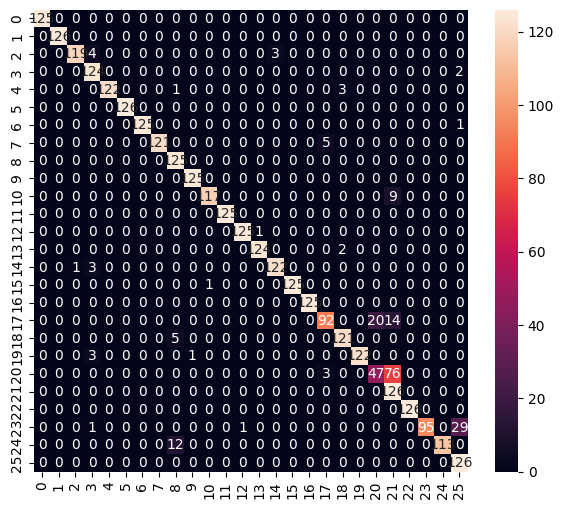

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       125
           1       1.00      1.00      1.00       126
           2       0.99      0.94      0.97       126
           3       0.92      0.98      0.95       126
           4       1.00      0.97      0.98       126
           5       1.00      1.00      1.00       126
           6       1.00      0.99      1.00       126
           7       1.00      0.96      0.98       126
           8       0.87      1.00      0.93       125
           9       0.99      1.00      1.00       125
          10       0.99      0.93      0.96       126
          11       1.00      1.00      1.00       125
          12       0.99      0.99      0.99       126
          13       0.99      0.98      0.99       126
          14       0.98      0.97      0.97       126
          15       1.00      0.99      1.00       126
          16       1.00      1.00      1.00       125
     

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Model Analysis

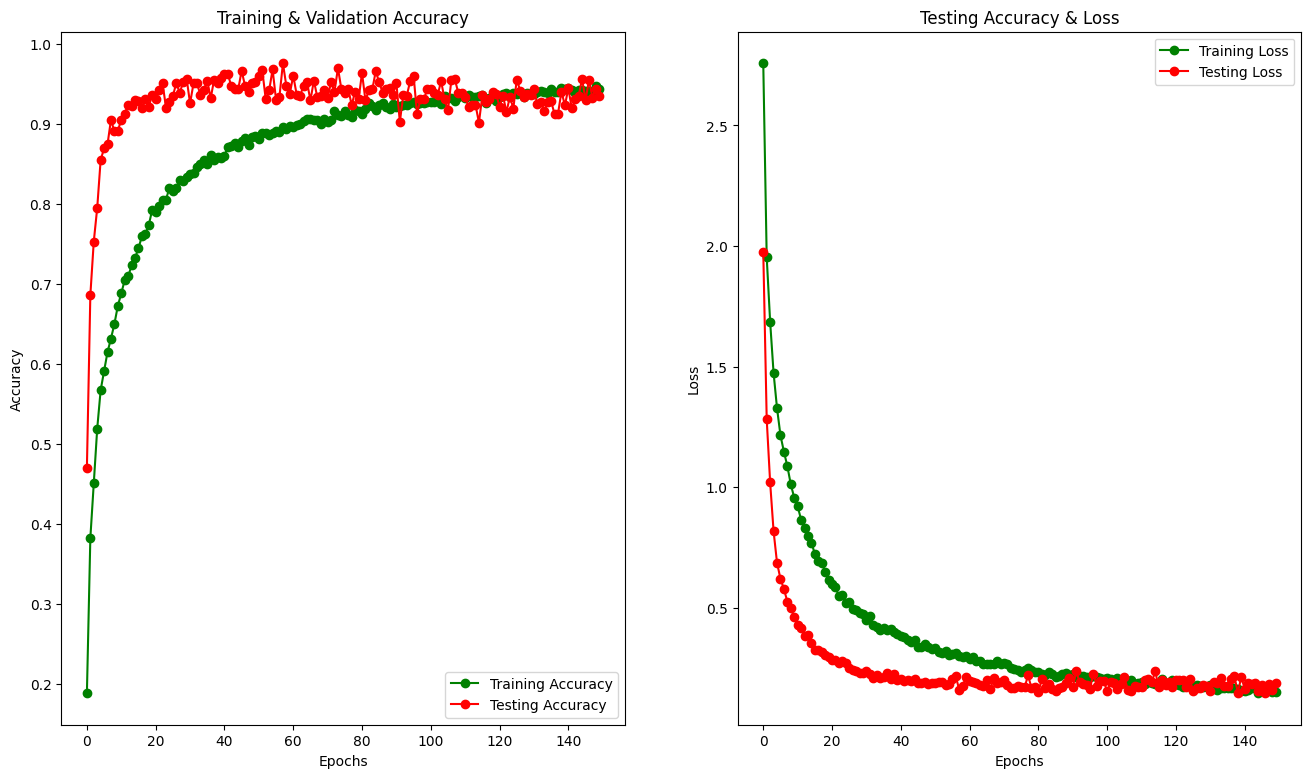

In [37]:
import matplotlib.pyplot as plt
epochs = [i for i in range(150)]
fig, ax = plt.subplots(1, 2)
train_acc = history.history["accuracy"]
train_loss = history.history["loss"]
val_acc = history.history["val_accuracy"]
val_loss = history.history["val_loss"]
fig.set_size_inches(16, 9)

ax[0].plot(epochs, train_acc, "go-", label="Training Accuracy")
ax[0].plot(epochs, val_acc, "ro-", label="Testing Accuracy")
ax[0].set_title("Training & Validation Accuracy")
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, "g-o", label="Training Loss")
ax[1].plot(epochs, val_loss, "r-o", label="Testing Loss")
ax[1].set_title("Testing Accuracy & Loss")
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

103/103 [==============================] - 0s 2ms/step


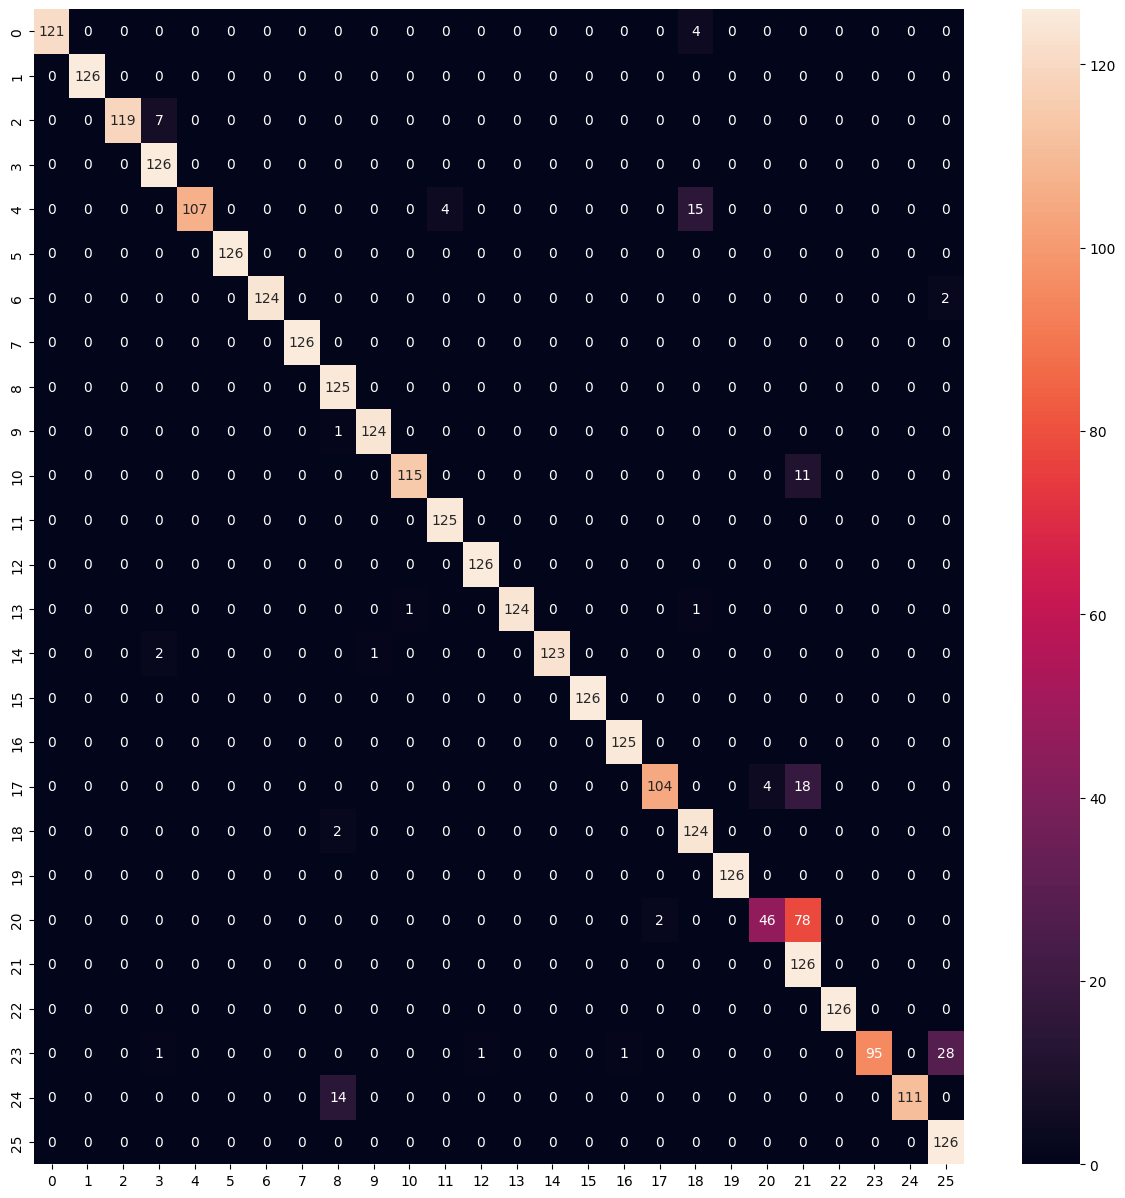

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.97      0.98       125
           1       1.00      1.00      1.00       126
           2       1.00      0.94      0.97       126
           3       0.93      1.00      0.96       126
           4       1.00      0.85      0.92       126
           5       1.00      1.00      1.00       126
           6       1.00      0.98      0.99       126
           7       1.00      1.00      1.00       126
           8       0.88      1.00      0.94       125
           9       0.99      0.99      0.99       125
          10       0.99      0.91      0.95       126
          11       0.97      1.00      0.98       125
          12       0.99      1.00      1.00       126
          13       1.00      0.98      0.99       126
          14       1.00      0.98      0.99       126
          15       1.00      1.00      1.00       126
          16       0.99      1.00      1.00       125
     

In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(15, 15))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [38]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [39]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\Alfian\AppData\Local\Temp\tmpfsilhia7\assets


INFO:tensorflow:Assets written to: C:\Users\Alfian\AppData\Local\Temp\tmpfsilhia7\assets


164704

# Inference test

In [14]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [15]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [16]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [17]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 4.68 ms


In [18]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[1.5574529e-05 6.3236989e-09 4.8830376e-08 5.3025028e-03 1.1707144e-07
 1.1157938e-07 2.7137569e-03 2.1514257e-02 4.6191201e-07 4.6058008e-03
 1.1691061e-06 5.4413607e-07 1.2143861e-04 5.1135288e-05 7.6437573e-05
 4.0408548e-05 8.7589643e-07 4.8954835e-06 3.2211243e-05 9.6401203e-01
 5.1206410e-08 1.1887925e-10 6.3315195e-13 1.4911322e-03 2.7602022e-07
 1.4837925e-05]
19


In [20]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [21]:
import string
def mapper_alphabet():
    nums = [i for i in range(1, 26)]
    alphabet = list(string.ascii_uppercase)
    alphabet.remove("J")
    alphabet.remove("Z")

    mapper = {}
    for num, alpha in zip(nums, alphabet):
        mapper[num] = alpha

    return mapper

In [22]:
import numpy as np
predictions = np.argmax(model.predict(X_test), axis=1)
for i in range(len(predictions)):
    predictions[i] += 1

103/103 [==============================] - 1s 3ms/step


In [40]:
from sklearn.utils import shuffle
import pandas as pd
df_pred_test = pd.DataFrame({"y_pred": predictions, "y_test": y_test})

df_pred_test["correct"] = np.where(
    df_pred_test["y_pred"] == df_pred_test["y_test"], True, False
)

df_pred_test["y_pred"] = df_pred_test["y_pred"].map(mapper_alphabet())
df_pred_test["y_test"] = df_pred_test["y_test"].map(mapper_alphabet())

shuffle(df_pred_test).head()

,y_pred,y_test,correct
1789,U,T,False
2094,L,K,False
2301,F,E,False
197,N,M,False
3221,NaN,NaN,False
